# Installs and Configuration

In [1]:
# Install packages, set configuration as needed
# gensim, worddcloud, python-Levenshtein
# !pip install gensim

In [2]:
# Import packages
# general purpose use throughout
import numpy as np
import pandas as pd
import os
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as col
from importlib import reload
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# feature extraction/selection methods
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

# model methods
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# custom files to keep notebook clean
import auxiliary as aux
import nlp_functions


%matplotlib inline

# Global Variables

In [3]:
# seed for random number/state generators
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# the proportion of data to reserve for testing; note that the smallest class only has 13 total instances
TEST_SIZE = 0.2
FOLDS = round(1/TEST_SIZE)

# These are the columns with Yes/No Answers
YN_ANS_COLS = ['Most Favored Nation-Answer', 'Competitive Restriction Exception-Answer', 
    'Non-Compete-Answer', 'Exclusivity-Answer', 'No-Solicit Of Customers-Answer',
    'No-Solicit Of Employees-Answer', 'Non-Disparagement-Answer', 
    'Termination For Convenience-Answer', 'Rofr/Rofo/Rofn-Answer', 'Change Of Control-Answer', 
    'Anti-Assignment-Answer', 'Revenue/Profit Sharing-Answer', 'Price Restrictions-Answer', 
    'Minimum Commitment-Answer', 'Volume Restriction-Answer', 'Ip Ownership Assignment-Answer', 
    'Joint Ip Ownership-Answer', 'License Grant-Answer', 'Non-Transferable License-Answer', 
    'Affiliate License-Licensor-Answer', 'Affiliate License-Licensee-Answer', 
    'Unlimited/All-You-Can-Eat-License-Answer', 'Irrevocable Or Perpetual License-Answer', 
    'Source Code Escrow-Answer', 'Post-Termination Services-Answer', 'Audit Rights-Answer', 
    'Uncapped Liability-Answer', 'Cap On Liability-Answer', 'Liquidated Damages-Answer', 
    'Insurance-Answer', 'Covenant Not To Sue-Answer','Third Party Beneficiary-Answer']

# column names for corresponding contract text
YN_TXT_COLS = ['Most Favored Nation', 'Competitive Restriction Exception', 'Non-Compete', 
    'Exclusivity', 'No-Solicit Of Customers', 'No-Solicit Of Employees', 'Non-Disparagement', 
    'Termination For Convenience', 'Rofr/Rofo/Rofn', 'Change Of Control', 'Anti-Assignment', 
    'Revenue/Profit Sharing', 'Price Restrictions', 'Minimum Commitment', 'Volume Restriction', 
    'Ip Ownership Assignment', 'Joint Ip Ownership', 'License Grant', 'Non-Transferable License',
    'Affiliate License-Licensor', 'Affiliate License-Licensee', 'Unlimited/All-You-Can-Eat-License', 
    'Irrevocable Or Perpetual License', 'Source Code Escrow', 'Post-Termination Services',
    'Audit Rights', 'Uncapped Liability', 'Cap On Liability', 'Liquidated Damages', 'Insurance',
    'Covenant Not To Sue','Third Party Beneficiary']

# Load and Arrange Data

CUAD_v1.zip was downloaded from https://zenodo.org/record/4595826#.YJp6hqhKiUk checksum md5:c38f490a984420b8a62600db401fafd5) on 5 May 2021. The file of interest is master_clauses.csv, but I do not know of a way to access/download only this file.

In [4]:
# through manual inspection of the csv, blanks or empty data can occur in the following formats:
na_values = {'[\'[â— ]\']', '[]', '[]/[]/[]', '[\'[*]\']', '[]/[]/[][]', ''}

# read the csv, marking as null the values listed above
df_master = pd.read_csv("master_clauses.csv", header=0, na_values=na_values)
# df_master.set_index('Filename')


The first of 83 columns of the dataframe is the text filename from the corpus. Each of the other 41 labels is represented by two columns: the extracted portion of contract text relevant to that label category, and the answer to the question posed by the category. For the first 8 categories and #38 Warrant Duration, the answers are relevant dates, durations, or names. The remaining 32 answers are Yes/No to indicate whether such a clause exists in the contract. The description of each of the 41 labels can be found at https://www.atticusprojectai.org/atticus-labels.

In [5]:
# display(df_master)
display(df_master.head())
# display(df_master.info())
# df_master.columns
# df_master.shape

,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['MARKETING AFFILIATE AGREEMENT'],MARKETING AFFILIATE AGREEMENT,"['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...","Birch First Global Investments Inc. (""Company""...","['8th day of May 2014', 'May 8, 2014']",5/8/2014,['This agreement shall begin upon the date of ...,NaN,['This agreement shall begin upon the date of ...,...,NaN,No,"[""COMPANY'S SOLE AND EXCLUSIVE LIABILITY FOR T...",Yes,NaN,No,NaN,No,NaN,No
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT'],VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT,"['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...","Rogers Cable Communications Inc. (""Rogers""); E...","['July 11 , 2006']",7/11/2006,"['July 11 , 2006']",7/11/2006,"['The term of this Agreement (the ""Initial Ter...",...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['CONTENT DISTRIBUTION AND LICENSE AGREEMENT'],CONTENT DISTRIBUTION AND LICENSE AGREEMENT,"['Producer', 'Fulucai Productions Ltd.', 'Conv...","CONVERGTV, INC. (“ConvergTV”); Fulucai Product...","['November 15, 2012']",11/15/2012,"['November 15, 2012']",11/15/2012,NaN,...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,['WEBSITE CONTENT LICENSE AGREEMENT'],WEBSITE CONTENT LICENSE AGREEMENT,"['PSiTech Corporation', 'Licensor', 'Licensee'...","PSiTech Corporation (""Licensor""); Empirical Ve...","['Feb 10, 2014']",2/10/2014,"['Feb 10, 2014']",2/10/2014,['The initial term of this Agreement commences...,...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,['CONTENT LICENSE AGREEMENT'],CONTENT LICENSE AGREEMENT,"['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...",Beijing Sun Seven Stars Culture Development Li...,"['December 21, 2015']",12/21/2015,"['December 21, 2015']",12/21/2015,"['The Term of this Agreement (the ""Term"") shal...",...,NaN,No,NaN,No,NaN,No,NaN,No,NaN,No


# Preprocessing Data

Next we will process the data to prepare it for transformations.

## Separating the Text Columns into Separate 'Sentences' per Observation

Here we abandon the horizontal association of clauses in the same contract, so each clause will be its own observation (row).

In [6]:
# Creates a new dataframe with only text from each YN field
data = {'sent' : [], 'Category':[]}
display(data)
# df_test = df_master[YN_TXT_COLS].stack().dropna().reset_index(drop=True)
# display(df_test)
df_yn_tmp = df_master[YN_TXT_COLS].replace(np.nan, '', regex=True)
# display(df_yn_tmp)
for col in YN_TXT_COLS:
    for i in range(len(df_yn_tmp[col])):
        sentence = df_yn_tmp[col].loc[i]
        if sentence:
            data['sent'].append(sentence)
            data['Category'].append(col)
del df_yn_tmp
df_yn_tmp = pd.DataFrame(data=data, columns=['sent', 'Category'])
display(df_yn_tmp)

{'sent': [], 'Category': []}

,sent,Category
0,['In the event that Licensor grants to another...,Most Favored Nation
1,"['If for any reason, Integrity and TL are subj...",Most Favored Nation
2,"[""The Company will, and Online BVI will cause ...",Most Favored Nation
3,"[""Such Prices and Volume Discount Prices shall...",Most Favored Nation
4,['All Users shall be treated at least as favor...,Most Favored Nation
...,...,...
3606,['Member hereby acknowledges and agrees that F...,Third Party Beneficiary
3607,['Lessor and Lessee expressly agree that Franc...,Third Party Beneficiary
3608,"['Except as expressly provided in Section 8, t...",Third Party Beneficiary
3609,"['Changepoint, Inc. (""Changepoint"") shall be a...",Third Party Beneficiary


## Apply Text Preprocessing to Sentences
- Remove special characters, punctuation, non-ASCII characters
- Expand contractions
- Normalize to lowercase
- Tokenization
- Lemmatization

In [7]:
token_file = 'sentences.pkl'
if os.path.exists(token_file):
    df_yn_txt = pd.read_pickle(token_file)
#     display(df_yn_txt)
else:
    df_yn_tmp['Clean'] = df_yn_tmp.loc[:,'sent'].apply(nlp_functions.clean_up_text)
    df_yn_tmp['Sentence'] = df_yn_tmp.loc[:,'Clean'].apply(nlp_functions.tokenize)
    # store the result in an np array of shape (510,)
    df_yn_txt = df_yn_tmp[['Sentence', 'Category']]
    df_yn_txt.to_pickle(token_file)
    print(f'{token_file} written.')
#     display(df_yn_txt)

## Text forms of x and y
Will need to convert/reduce strings to numbers for classification algorithms

In [8]:
display(df_yn_txt)
x_txt = df_yn_txt['Sentence'].squeeze()
y_txt = df_yn_txt['Category'].squeeze()

,Sentence,Category
0,"[event, licensor, grant, another, vod, pay, pe...",Most Favored Nation
1,"[reason, integrity, subject, lower, free, good...",Most Favored Nation
2,"[company, online, bvi, cause, company, use, co...",Most Favored Nation
3,"[price, volume, discount, price, shall, subjec...",Most Favored Nation
4,"[user, shall, treat, least, favorable, respect...",Most Favored Nation
...,...,...
3606,"[member, hereby, acknowledge, agree, franchiso...",Third Party Beneficiary
3607,"[lessor, lessee, expressly, agree, franchisor,...",Third Party Beneficiary
3608,"[except, expressly, provide, section, agreemen...",Third Party Beneficiary
3609,"[changepoint, inc, changepoint, shall, direct,...",Third Party Beneficiary


# Data Exploration and Visualization

## Frequency Information

In [9]:
ans_pkl = 'ans01.pkl'
if os.path.exists(ans_pkl):
    df_yn_ans = df_master[YN_ANS_COLS]
    df_01_ans = pd.read_pickle(ans_pkl)
else:
    # Make a new dataframe that contains only the Y/N columns
    df_yn_ans = df_master[YN_ANS_COLS]
    # display(df_yn)
    # Transform the columns to numbers
    df_01_ans = pd.DataFrame(np.where(df_yn_ans.values == 'Yes', 1, 0), df_yn_ans.index, columns=YN_ANS_COLS)
    df_01_ans.to_pickle(ans_pkl)

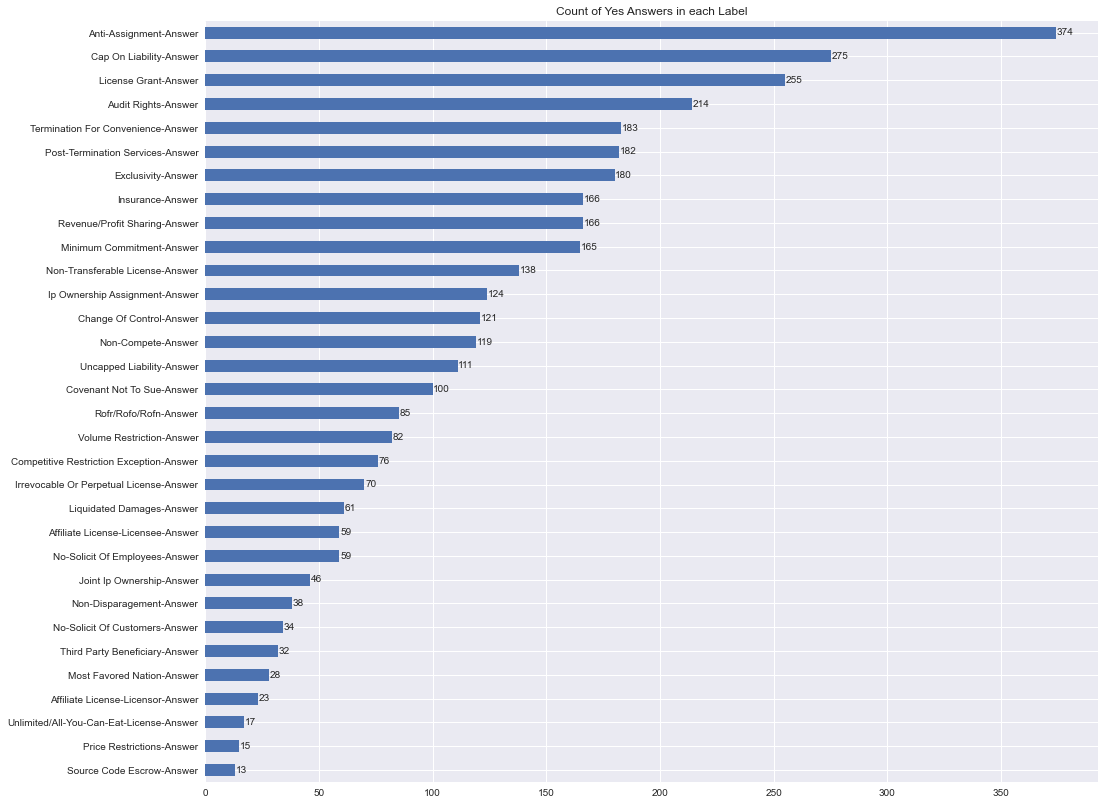

In [10]:
# print('Nonzeros (of 510 contracts) in each column')
freq = df_01_ans.astype(bool).sum(axis=0).sort_values()
# print(df_01_ans.astype(bool).sum(axis=0))
ax = freq.plot.barh(figsize=(16,14),title='Count of Yes Answers in each Label')
for i in range(len(freq)):
    ax.text(freq[i]+0.3, i-0.1, freq[i])
 

## Calculating the co-occurence (correlation) of labeled passages

In [11]:
corr = aux.correlation_views(df=df_01_ans, print_top=20, diag=-2)

,Most Favored Nation-Answer,Competitive Restriction Exception-Answer,Non-Compete-Answer,Exclusivity-Answer,No-Solicit Of Customers-Answer,No-Solicit Of Employees-Answer,Non-Disparagement-Answer,Termination For Convenience-Answer,Rofr/Rofo/Rofn-Answer,Change Of Control-Answer,Anti-Assignment-Answer,Revenue/Profit Sharing-Answer,Price Restrictions-Answer,Minimum Commitment-Answer,Volume Restriction-Answer,Ip Ownership Assignment-Answer,Joint Ip Ownership-Answer,License Grant-Answer,Non-Transferable License-Answer,Affiliate License-Licensor-Answer,Affiliate License-Licensee-Answer,Unlimited/All-You-Can-Eat-License-Answer,Irrevocable Or Perpetual License-Answer,Source Code Escrow-Answer,Post-Termination Services-Answer,Audit Rights-Answer,Uncapped Liability-Answer,Cap On Liability-Answer,Liquidated Damages-Answer,Insurance-Answer,Covenant Not To Sue-Answer,Third Party Beneficiary-Answer
Most Favored Nation-Answer,-2.00,0.02,0.05,0.15,-0.03,-0.01,-0.00,0.05,0.05,0.05,0.13,0.07,0.01,0.13,0.15,0.06,0.10,0.09,0.05,0.07,0.07,0.10,0.05,-0.04,0.11,0.11,0.06,0.12,-0.01,0.05,0.03,0.01
Competitive Restriction Exception-Answer,0.02,-2.00,0.38,0.35,0.24,0.24,0.13,-0.03,0.27,0.22,0.19,0.19,0.02,0.19,0.13,0.19,0.04,0.23,0.18,0.07,0.07,-0.05,0.06,0.07,0.19,0.21,0.15,0.14,0.15,0.16,0.14,0.12
Non-Compete-Answer,0.05,0.38,-2.00,0.25,0.26,0.25,0.11,0.07,0.25,0.20,0.22,0.33,-0.04,0.14,0.14,0.23,0.18,0.27,0.25,0.08,0.06,0.00,0.17,0.06,0.29,0.25,0.16,0.15,0.14,0.15,0.24,0.11
Exclusivity-Answer,0.15,0.35,0.25,-2.00,0.05,0.02,0.13,-0.06,0.25,0.19,0.22,0.26,0.07,0.28,0.22,0.19,0.21,0.39,0.23,0.02,0.17,0.05,0.10,-0.02,0.28,0.27,0.11,0.18,0.07,0.23,0.23,-0.00
No-Solicit Of Customers-Answer,-0.03,0.24,0.26,0.05,-2.00,0.35,0.07,0.03,0.11,0.13,0.09,0.10,0.05,0.03,0.01,0.18,0.05,0.02,0.03,0.02,0.00,-0.05,-0.02,0.01,0.11,0.11,0.03,0.03,0.12,0.13,0.15,0.09
No-Solicit Of Employees-Answer,-0.01,0.24,0.25,0.02,0.35,-2.00,0.08,0.22,0.17,0.16,0.12,0.08,0.05,0.03,-0.04,0.24,-0.05,0.07,0.06,0.04,-0.02,-0.03,0.11,0.06,0.14,0.04,0.02,0.03,0.17,0.13,0.11,0.13
Non-Disparagement-Answer,-0.00,0.13,0.11,0.13,0.07,0.08,-2.00,-0.06,0.05,0.03,0.10,0.04,-0.05,0.09,0.04,0.14,0.01,0.15,0.13,-0.03,-0.01,-0.05,0.02,-0.05,0.07,0.02,-0.04,-0.02,0.03,0.14,0.22,0.02
Termination For Convenience-Answer,0.05,-0.03,0.07,-0.06,0.03,0.22,-0.06,-2.00,0.02,0.08,0.19,-0.01,-0.01,-0.02,-0.07,0.14,0.04,0.09,0.10,0.09,0.13,-0.07,0.18,0.14,0.13,0.13,0.09,0.24,0.10,0.19,-0.02,0.01
Rofr/Rofo/Rofn-Answer,0.05,0.27,0.25,0.25,0.11,0.17,0.05,0.02,-2.00,0.18,0.19,0.21,0.02,0.16,0.02,0.18,0.19,0.17,0.15,0.08,0.13,0.00,0.16,-0.01,0.21,0.20,0.11,0.13,0.06,0.23,0.11,0.10
Change Of Control-Answer,0.05,0.22,0.20,0.19,0.13,0.16,0.03,0.08,0.18,-2.00,0.32,0.18,0.07,0.07,0.02,0.30,0.15,0.26,0.26,0.15,0.17,-0.00,0.14,0.11,0.23,0.31,0.14,0.25,0.18,0.18,0.22,0.08


Top Absolute Correlations (excluding diagonals)
License Grant-Answer                      Non-Transferable License-Answer            0.591417
Uncapped Liability-Answer                 Cap On Liability-Answer                    0.487576
Affiliate License-Licensor-Answer         Affiliate License-Licensee-Answer          0.423597
Audit Rights-Answer                       Cap On Liability-Answer                    0.411370
Post-Termination Services-Answer          Audit Rights-Answer                        0.403331
Anti-Assignment-Answer                    License Grant-Answer                       0.399059
Exclusivity-Answer                        License Grant-Answer                       0.393893
Affiliate License-Licensee-Answer         Irrevocable Or Perpetual License-Answer    0.390179
Ip Ownership Assignment-Answer            Irrevocable Or Perpetual License-Answer    0.384941
Competitive Restriction Exception-Answer  Non-Compete-Answer                         0.381004
License Gran

Very few of the columns had significant correlation with each other. The higest correlation values suggest a moderate relationship between some of the columns.

# Transforming Data

Next we will transform and analyze the data to prepare it for classification algorithms.

## Converting the y_txt to y_num

In [12]:
y_num = y_txt.loc[:,].apply(YN_TXT_COLS.index)
print(y_num)

0        0
1        0
2        0
3        0
4        0
        ..
3606    31
3607    31
3608    31
3609    31
3610    31
Name: Category, Length: 3611, dtype: int64


Here we investigate different methods of feature extraction and word embedding for use in classification algorithims

## Creating total and class vocabularies from x_txt

In [13]:
total_vocab, class_vocab = aux.build_vocab_word_counts(x_txt, y_num)

In [14]:
print(f'There are {len(total_vocab)} unique tokenized words from {len(x_txt)} sentences in the x_txt vocabulary')
print(f'There are {len(class_vocab[0])} unique tokenized words for class 0 vocabulary')
print(f'Array from total_vocab[\'event\'] : {total_vocab["event"]}')
print(f'Count from class_vocab[0][\'event\'] : {class_vocab[0]["event"]}')
print(f'The 10 most common words and counts in class 0 are: \n{class_vocab[0].most_common(10)}')

There are 6249 unique tokenized words from 3611 sentences in the x_txt vocabulary
There are 476 unique tokenized words for class 0 vocabulary
Array from total_vocab['event'] : [  9.  30.  21.  27.   1.   6.   5.   7.  60.  88.  47.  35.   2.  80.
  15.  16.   7.  39.  16.   2.   3.   0.  10.  18.  98.  21.  81. 267.
  40.  30.   9.   2.]
Count from class_vocab[0]['event'] : 9
The 10 most common words and counts in class 0 are: 
[('shall', 46), ('agreement', 45), ('terms', 36), ('provide', 26), ('product', 26), ('party', 25), ('license', 23), ('price', 23), ('fee', 16), ('favorable', 16)]


## Converting the x_txt to numerical features using vocabularies

In [15]:
x_class_nums, x_sent_lens = aux.txt_to_class_num(x_txt, class_vocab)
x_class_nums_df = pd.DataFrame(data=x_class_nums)

In [16]:
display(x_class_nums_df)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,161.0,114.0,131.0,132.0,93.0,95.0,78.0,120.0,130.0,123.0,...,119.0,105.0,135.0,137.0,100.0,127.0,104.0,125.0,107.0,55.0
1,15.0,12.0,12.0,13.0,7.0,8.0,8.0,10.0,11.0,11.0,...,11.0,8.0,13.0,14.0,11.0,12.0,13.0,13.0,9.0,5.0
2,72.0,55.0,54.0,62.0,44.0,41.0,41.0,42.0,56.0,51.0,...,55.0,37.0,59.0,62.0,38.0,53.0,44.0,51.0,41.0,22.0
3,41.0,30.0,28.0,37.0,21.0,20.0,17.0,29.0,32.0,21.0,...,26.0,20.0,39.0,34.0,28.0,39.0,34.0,27.0,19.0,8.0
4,21.0,12.0,12.0,16.0,9.0,9.0,8.0,10.0,16.0,15.0,...,14.0,12.0,16.0,16.0,11.0,17.0,13.0,14.0,11.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,18.0,29.0,31.0,35.0,23.0,25.0,25.0,18.0,35.0,35.0,...,23.0,25.0,37.0,31.0,25.0,35.0,28.0,38.0,28.0,41.0
3607,3.0,5.0,5.0,6.0,5.0,5.0,4.0,5.0,5.0,7.0,...,4.0,5.0,7.0,7.0,5.0,7.0,4.0,8.0,6.0,9.0
3608,7.0,9.0,10.0,10.0,9.0,9.0,7.0,8.0,10.0,10.0,...,9.0,11.0,9.0,10.0,10.0,10.0,9.0,11.0,10.0,11.0
3609,4.0,7.0,9.0,7.0,6.0,6.0,5.0,4.0,7.0,7.0,...,7.0,10.0,9.0,9.0,9.0,10.0,5.0,8.0,7.0,10.0


In [17]:
x_total_nums, x_sent_lens = aux.txt_to_total_num(x_txt, total_vocab)
x_total_nums_df = pd.DataFrame(data=x_total_nums, columns=total_vocab.keys())

In [18]:
display(x_total_nums_df)

,event,licensor,grant,another,vod,pay,per,view,ppv,service,...,acquit,releasors,unsuspected,releasor,releasee,improper,infringment,jury,oms,redemption
0,1.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classifier Model Examples

## Example Models (on x with unfairly whole vocabulary)

In [19]:
total_cv_pkl = 'total_cv.pkl'
class_cv_pkl = 'class_cv.pkl'
if os.path.exists(total_cv_pkl):
    total_cv_df = pd.read_pickle(total_cv_pkl)
else:
    total_cv_df = aux.model_test(features=x_total_nums, labels=y_num, folds=5, seed=SEED)
    total_cv_df.to_pickle(total_cv_pkl)
if os.path.exists(class_cv_pkl):
    class_cv_df = pd.read_pickle(class_cv_pkl)
else:
    class_cv_df = aux.model_test(features=x_class_nums, labels=y_num, folds=5, seed=SEED)
    class_cv_df.to_pickle(class_cv_pkl)

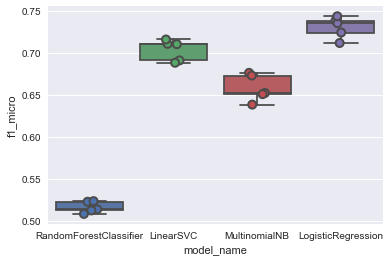

model_name
LinearSVC                 0.703404
LogisticRegression        0.730820
MultinomialNB             0.658261
RandomForestClassifier    0.516199
Name: f1_micro, dtype: float64

In [20]:
aux.model_eval(total_cv_df, ylabel='f1_micro')

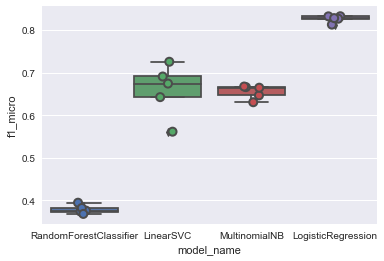

model_name
LinearSVC                 0.659124
LogisticRegression        0.826639
MultinomialNB             0.655227
RandomForestClassifier    0.379120
Name: f1_micro, dtype: float64

In [21]:
aux.model_eval(class_cv_df)

## Example of splitting the data into train and test sets with stratified class sampling

'total x shape: (3611,)'

'total y shape: (3611,)'

'train X shape with 1/2 samples: (1806, 4516)'

'train y shape: (1806,)'

'train X shape with 1/2 samples: (1805, 4516)'

'test y shape: (1805,)'

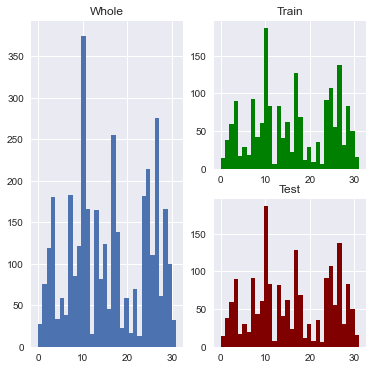

In [22]:
aux.example_split(X=x_txt, y=y_num, folds=2)

# Model Parameter Searches

## Actual Train/Test Split and Preparation

In [23]:
skf = StratifiedKFold(n_splits=FOLDS)
for train_index, test_index in skf.split(x_txt, y_num):
    X_train, X_test = x_txt[train_index], x_txt[test_index]
    y_train, y_test = y_num[train_index], y_num[test_index]
# only actually using the last set of indices
train_vocab, train_class_vocab = aux.build_vocab_word_counts(X_train, y_train)
X_train_num, X_train_lens = aux.txt_to_total_num(X_train, train_vocab)
X_test_num, X_test_lens = aux.txt_to_total_num(X_test, train_vocab)

In [24]:
display(f'total x shape: {x_txt.shape}')
display(f'total y shape: {y_num.shape}')
display(f'train X shape with {FOLDS-1}/{FOLDS} samples: {X_train_num.shape}')
display(f'train y shape: {y_train.shape}')
display(f'test X shape with 1/{FOLDS} samples: {X_test_num.shape}')
display(f'test y shape: {y_test.shape}')

'total x shape: (3611,)'

'total y shape: (3611,)'

'train X shape with 4/5 samples: (2889, 5650)'

'train y shape: (2889,)'

'test X shape with 1/5 samples: (722, 5650)'

'test y shape: (722,)'

## Random Forest Classifier

In [25]:
rfc_pkl = 'rfc_search.pkl'
if os.path.exists(rfc_pkl):
    rfc_df = pd.read_pickle(rfc_pkl)
    best_loc = np.nanargmax(rfc_df['mean_test'])
    print(f'Best: {rfc_df["mean_test"][best_loc]:.3f} (+/-{rfc_df["2xstd_test"][best_loc] * 2:.3f}) for {rfc_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(rfc_df.sort_values(by='mean_test', ascending=False))
else:
    rfc_grid_search = aux.model_search(X_train_num, y_train, model='rfc', seed=SEED, folds=FOLDS)
    aux.display_search_results(rfc_grid_search, filename=rfc_pkl)
    

Best: 0.639 (+/-0.045) for {'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': 0.6, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}


,mean_test,2xstd_test,mean_train,2xstd_train,params
515,0.639454,0.022507,0.853509,0.014463,"{'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': 0.9, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}"
514,0.639454,0.022507,0.853509,0.014463,"{'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': None, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}"
513,0.639454,0.022507,0.853509,0.014463,"{'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}"
512,0.639454,0.022507,0.853509,0.014463,"{'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': 0.6, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}"
496,0.637373,0.017188,0.852293,0.014199,"{'rfc__bootstrap': False, 'rfc__max_depth': 15, 'rfc__max_samples': None, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 200}"
...,...,...,...,...,...
182,0.341667,0.084266,0.412993,0.053941,"{'rfc__bootstrap': True, 'rfc__max_depth': 3, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 300}"
185,0.341667,0.084266,0.405156,0.047134,"{'rfc__bootstrap': True, 'rfc__max_depth': 3, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 300}"
184,0.338492,0.086450,0.406743,0.057375,"{'rfc__bootstrap': True, 'rfc__max_depth': 3, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 200}"
188,0.335417,0.072648,0.390276,0.036690,"{'rfc__bootstrap': True, 'rfc__max_depth': 3, 'rfc__max_samples': 0.3, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 300}"


0.8383523710626515


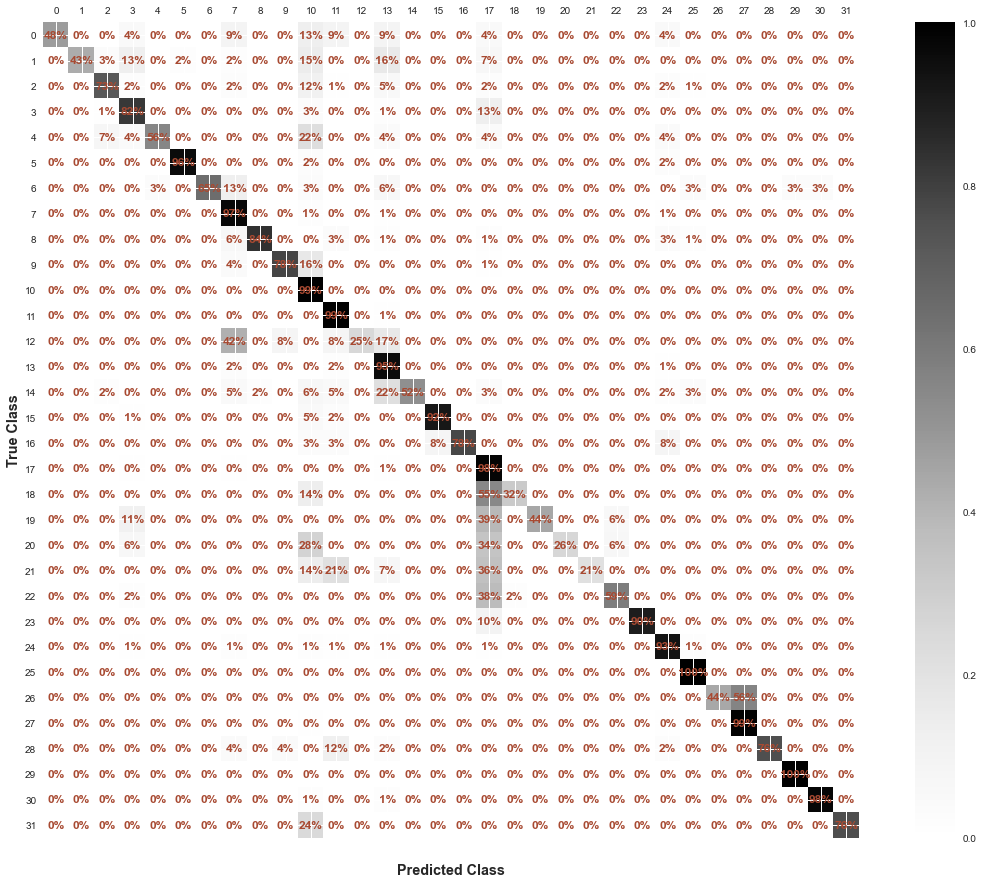

In [26]:
best_rfc = RandomForestClassifier(random_state=SEED, bootstrap=False, 
      max_depth=15, max_samples=0.6, min_samples_split=4, n_estimators=300)
best_rfc.fit(X_train_num, y_train)
y_train_pred_rfc = best_rfc.predict(X_train_num)
print(best_rfc.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_rfc)

In [27]:
print('Reminder of Class Distributions:')
df_classes = pd.DataFrame(data={'Class': np.arange(32),
    'Counts': df_01_ans.astype(bool).sum(axis=0)},)
display(df_classes)

Reminder of Class Distributions:


,Class,Counts
Most Favored Nation-Answer,0,28
Competitive Restriction Exception-Answer,1,76
Non-Compete-Answer,2,119
Exclusivity-Answer,3,180
No-Solicit Of Customers-Answer,4,34
No-Solicit Of Employees-Answer,5,59
Non-Disparagement-Answer,6,38
Termination For Convenience-Answer,7,183
Rofr/Rofo/Rofn-Answer,8,85
Change Of Control-Answer,9,121


## Logistic Regression

In [28]:
logreg_pkl = 'logreg_search.pkl'
if os.path.exists(logreg_pkl):
    logreg_df = pd.read_pickle(logreg_pkl)
    best_loc = np.nanargmax(logreg_df['mean_test'])
    print(f'Best: {logreg_df["mean_test"][best_loc]:.3f} (+/-{logreg_df["2xstd_test"][best_loc] * 2:.3f}) for {logreg_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(logreg_df.sort_values(by='mean_test', ascending=False))
else:
    logreg_grid_search = aux.model_search(X_train_num, y_train, model='logreg', seed=SEED, folds=FOLDS)
    aux.display_search_results(logreg_grid_search, filename=logreg_pkl)

Best: 0.717 (+/-0.078) for {'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}


,mean_test,2xstd_test,mean_train,2xstd_train,params
21,0.717203,0.039057,0.957685,0.007487,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
20,0.717203,0.039057,0.957685,0.007487,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
19,0.664583,0.081116,0.987532,0.011685,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
18,0.664583,0.081116,0.987532,0.011685,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
17,0.664583,0.081116,0.987532,0.011685,"{'logreg__max_iter': 100, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
16,0.661458,0.089365,0.971429,0.031641,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
15,0.645833,0.086653,0.939481,0.056444,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'sag'}"
2,0.603125,0.085239,0.994531,0.006250,"{'logreg__max_iter': 100, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
7,0.603125,0.085239,0.994531,0.006250,"{'logreg__max_iter': 250, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"
12,0.603125,0.085239,0.994531,0.006250,"{'logreg__max_iter': 500, 'logreg__multi_class': 'auto', 'logreg__solver': 'liblinear'}"


0.9532710280373832


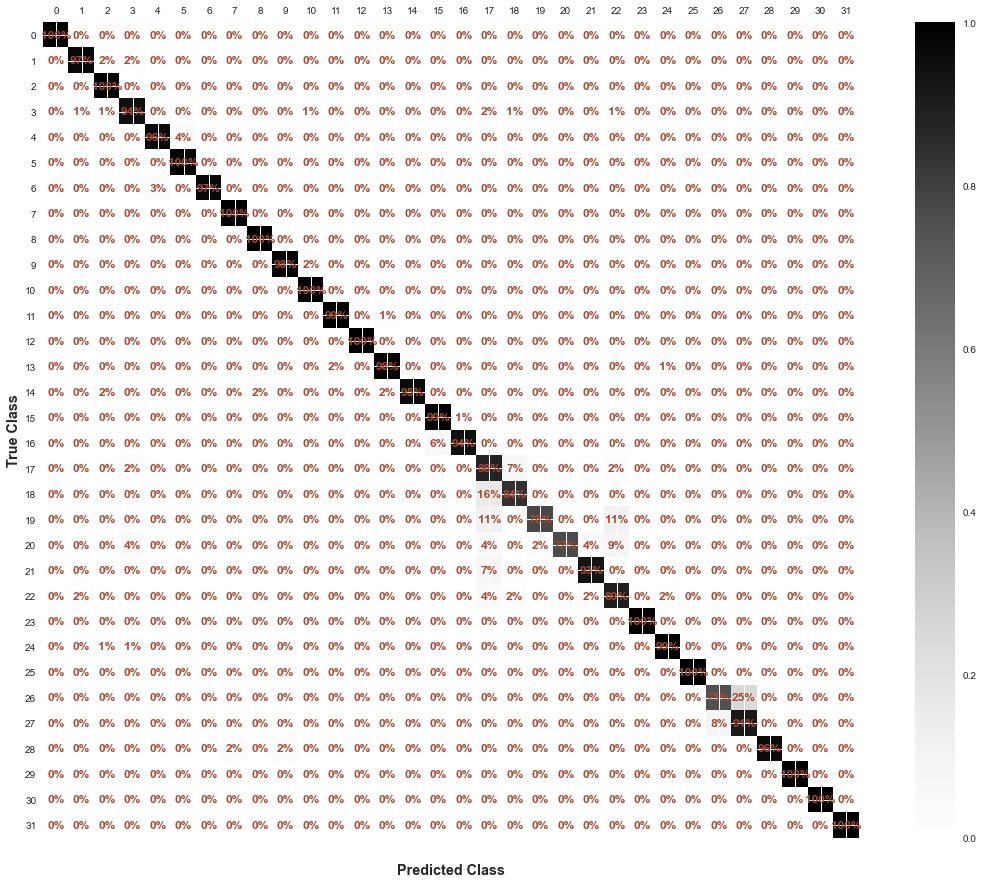

In [29]:
best_logreg = LogisticRegression(random_state=SEED, max_iter=250, multi_class='auto', solver='liblinear')
best_logreg.fit(X_train_num, y_train)
y_train_pred_logreg = best_logreg.predict(X_train_num)
print(best_logreg.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_logreg)

## Multinomial Naive Bayes

In [30]:
mnb_pkl = 'mnb_search.pkl'
if os.path.exists(mnb_pkl):
    mnb_df = pd.read_pickle(mnb_pkl)
    best_loc = np.nanargmax(mnb_df['mean_test'])
    print(f'Best: {mnb_df["mean_test"][best_loc]:.3f} (+/-{mnb_df["2xstd_test"][best_loc] * 2:.3f}) for {mnb_df["params"][best_loc]}')
    with pd.option_context("display.max_colwidth", 1000):
        display(mnb_df.sort_values(by='mean_test', ascending=False))
else:
    mnb_grid_search = aux.model_search(X_train_num, y_train, model='mnb', seed=SEED, folds=FOLDS)
    aux.display_search_results(mnb_grid_search, filename=mnb_pkl)

Best: 0.640 (+/-0.129) for {'mnb__alpha': 0.26}


,mean_test,2xstd_test,mean_train,2xstd_train,params
106,0.640205,0.064311,0.918923,0.013191,{'mnb__alpha': 0.26}
113,0.639163,0.064754,0.922573,0.013408,{'mnb__alpha': 0.25}
114,0.638122,0.069637,0.925441,0.012966,{'mnb__alpha': 0.24}
112,0.638122,0.070258,0.928570,0.010393,{'mnb__alpha': 0.23}
110,0.638122,0.069637,0.916316,0.013804,{'mnb__alpha': 0.27}
...,...,...,...,...,...
99,0.457937,0.163108,0.840910,0.010577,{'mnb__alpha': 0.99}
96,0.457937,0.163108,0.842479,0.013386,{'mnb__alpha': 0.96}
97,0.457937,0.163108,0.842479,0.013386,{'mnb__alpha': 0.97}
98,0.457937,0.163108,0.841694,0.011648,{'mnb__alpha': 0.98}


0.8560055382485289


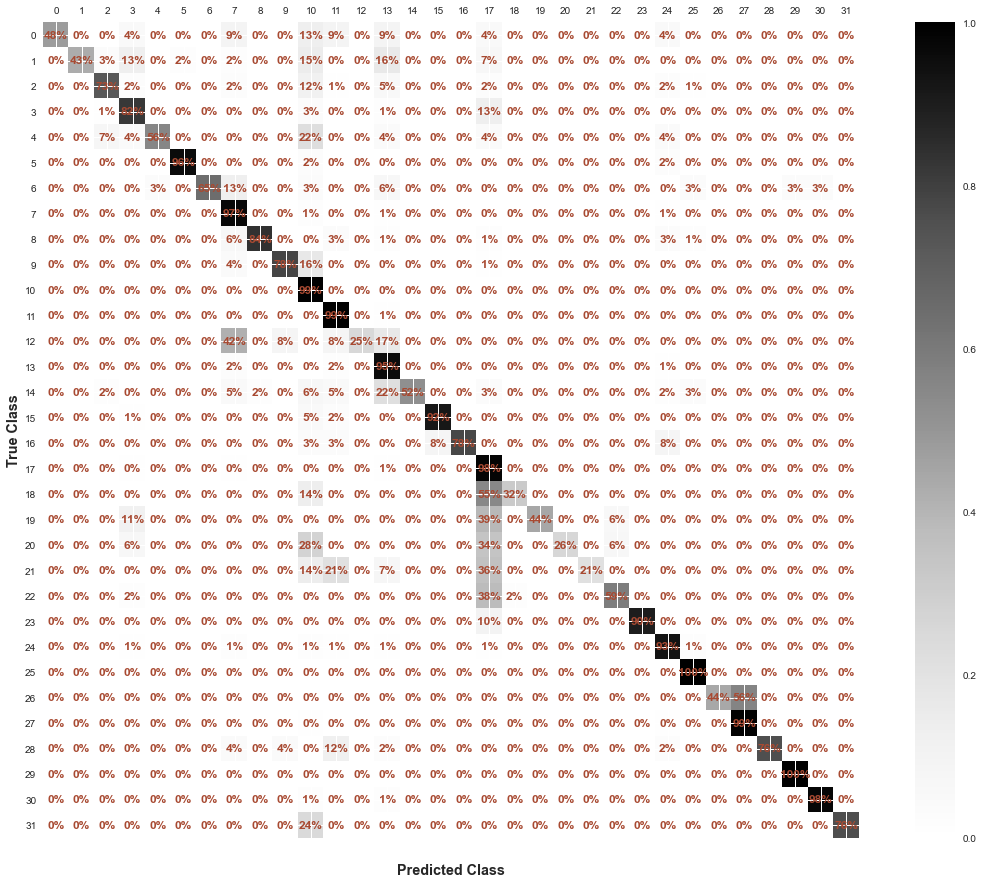

In [31]:
best_mnb = MultinomialNB(alpha=0.26)
best_mnb.fit(X_train_num, y_train)
y_train_pred_mnb = best_rfc.predict(X_train_num)
print(best_mnb.score(X_train_num, y_train))
aux.show_conf_matrix(y_train, y_train_pred_mnb)

# RELOAD

In [32]:
# run this to update the auxiliary import after making changes
reload(aux)

<module 'auxiliary' from 'C:\\Users\\raind\\WORK\\AFIT\\21SP\\CSCE623\\Project\\auxiliary.py'>

# EOF